# Preprocessing audio data for deep learning

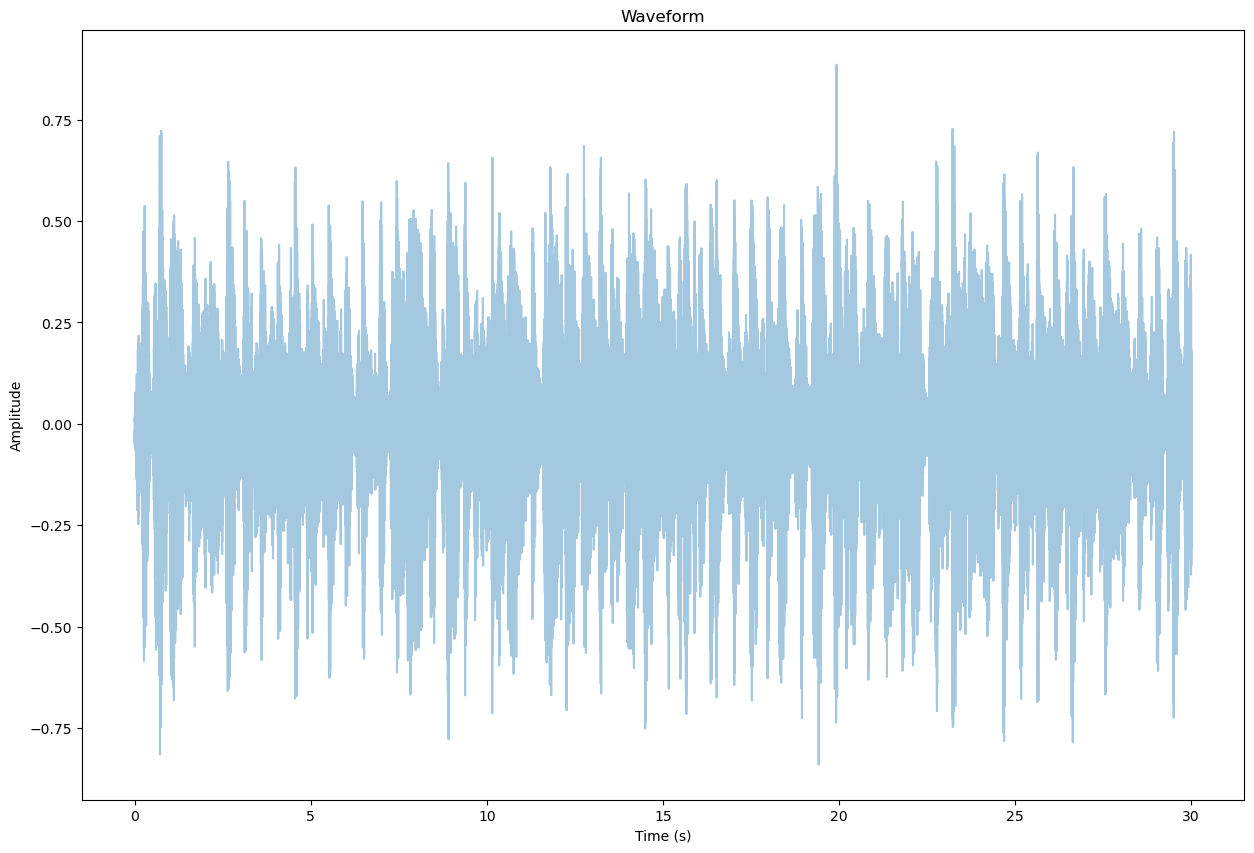

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

FIG_SIZE = (15,10)
file =r"C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\blues.00000.wav"

try:
    # Load audio file
    signal, sample_rate = librosa.load(file, sr=22050)
    
    # WAVEFORM
    plt.figure(figsize=FIG_SIZE)
    plt.plot(np.linspace(0, len(signal) / sample_rate, num=len(signal)), signal, alpha=0.4)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Waveform")
    plt.show()
    
except FileNotFoundError as e:
    print(f"File not found: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


Text(0.5, 1.0, 'Power spectrum')

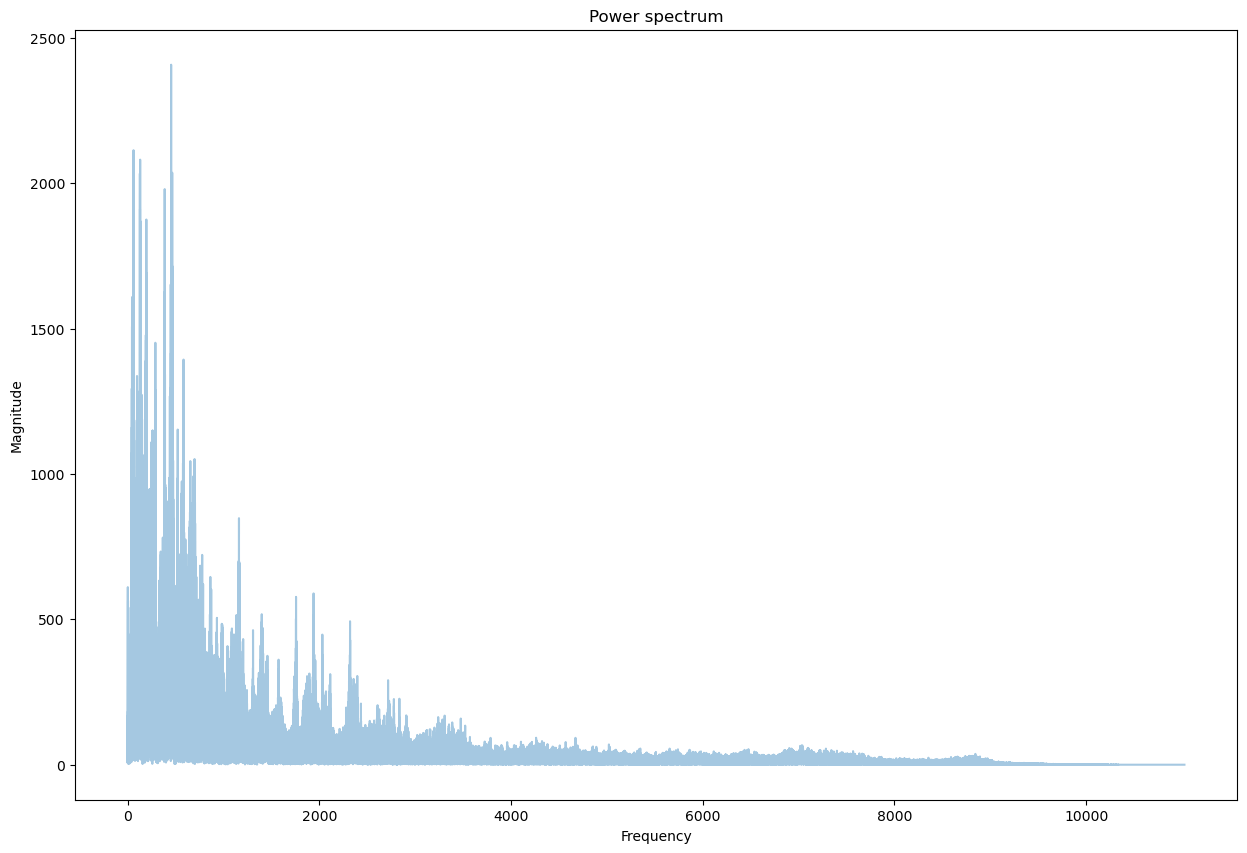

In [4]:
# FFT -> power spectrum
# perform Fourier transform
fft = np.fft.fft(signal)

# calculate abs values on complex numbers to get magnitude
spectrum = np.abs(fft)

# create frequency variable
f = np.linspace(0, sample_rate, len(spectrum))

# take half of the spectrum and frequency
left_spectrum = spectrum[:int(len(spectrum)/2)]
left_f = f[:int(len(spectrum)/2)]

# plot spectrum
plt.figure(figsize=FIG_SIZE)
plt.plot(left_f, left_spectrum, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")


STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


Text(0.5, 1.0, 'Spectrogram (dB)')

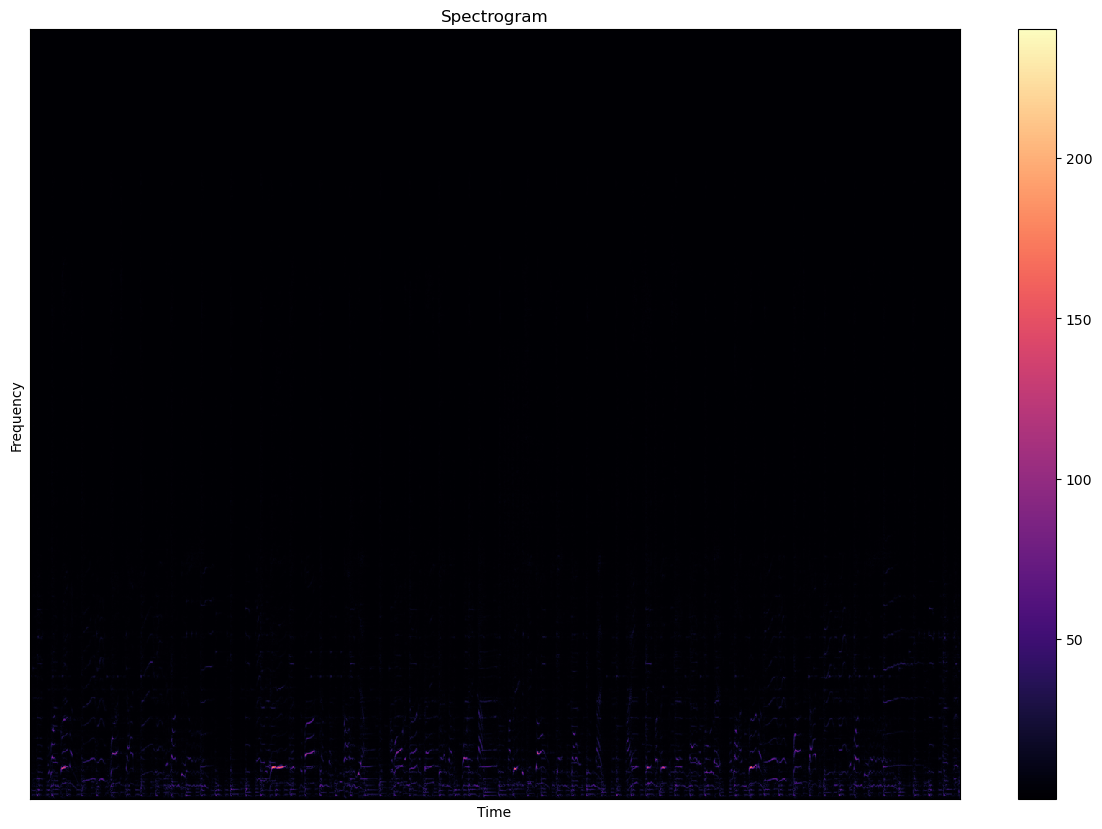

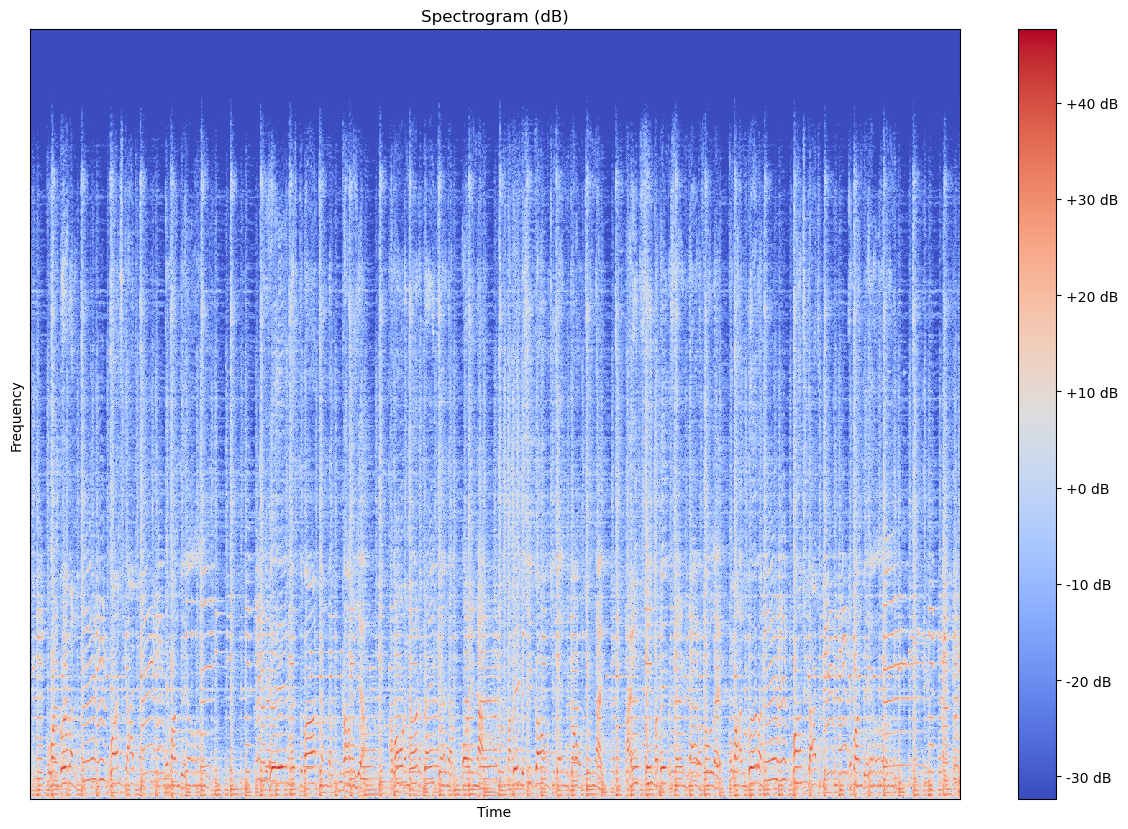

In [5]:

# STFT -> spectrogram
hop_length = 512 # in num. of samples
n_fft = 2048 # window in num. of samples

# calculate duration hop length and window in seconds
hop_length_duration = float(hop_length)/sample_rate
n_fft_duration = float(n_fft)/sample_rate

print("STFT hop length duration is: {}s".format(hop_length_duration))
print("STFT window duration is: {}s".format(n_fft_duration))

# perform stft
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

# calculate abs values on complex numbers to get magnitude
spectrogram = np.abs(stft)

# display spectrogram
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")

# apply logarithm to cast amplitude to Decibels
log_spectrogram = librosa.amplitude_to_db(spectrogram)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")


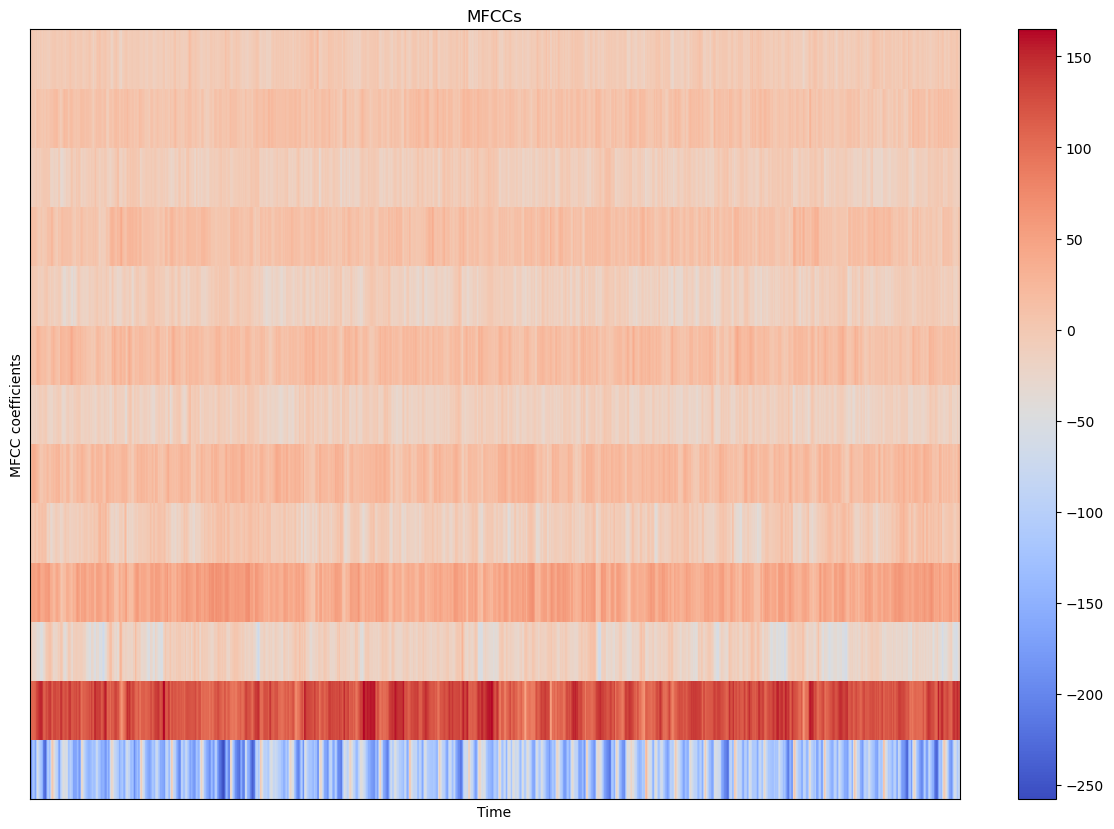

In [6]:
try:
    # Load audio file
    signal, sample_rate = librosa.load(file, sr=22050)
    
    # MFCCs
    # extract 13 MFCCs
    MFCCs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
    
    # Display MFCCs
    plt.figure(figsize=FIG_SIZE)
    librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
    plt.xlabel("Time")
    plt.ylabel("MFCC coefficients")
    plt.colorbar()
    plt.title("MFCCs")
    plt.show()
    
except FileNotFoundError as e:
    print(f"File not found: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


# 

# Music genre classification: Preparing the dataset

In [11]:
import json
import os

def create_empty_json_in_folder(folder_path, file_name):
    """Creates an empty JSON file with the given file name in the specified folder."""
    try:
        # Ensure the folder exists
        os.makedirs(folder_path, exist_ok=True)
        
        # Define the full file path
        file_path = os.path.join(folder_path, file_name)
        
        # Create an empty dictionary
        data = {}
        
        # Write the empty dictionary to the JSON file
        with open(file_path, 'w') as file:
            json.dump(data, file, indent=4)
        
        print(f"Empty JSON file created successfully at {file_path}!")
    except Exception as e:
        print(f"Error creating JSON file: {e}")

# Specify the folder path and file name
folder_path = r"C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project"  # Change this to your desired folder path
file_name = "yash.json"

# Create the empty JSON file
create_empty_json_in_folder(folder_path, file_name)



Empty JSON file created successfully at C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project\yash.json!


In [12]:
import json
import os
import math
import librosa
import soundfile as sf
import audioread

DATASET_PATH = r"C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original"
JSON_PATH = r"C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project\yash.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along with genre labels.

        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

                # load audio file
                file_path = os.path.join(dirpath, f)
                try:
                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
                    continue

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    try:
        with open(json_path, "w") as fp:
            json.dump(data, fp, indent=4)
        print("Data successfully saved to", json_path)
    except Exception as e:
        print(f"Error saving JSON file: {e}")

if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)


Processing: C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00000.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00000.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00000.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00000.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00000.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00000.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00000.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\g

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00008.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00008.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00008.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00008.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00008.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00008.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00008.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00008.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Pr

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00016.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00016.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00016.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00016.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00016.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00016.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00016.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00016.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Pr

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00023.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00023.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00023.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00023.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00023.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00023.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00024.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00024.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\P

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00030.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00030.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00030.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00030.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00030.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00030.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00031.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00031.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\P

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00037.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00038.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00038.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00038.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00038.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00038.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00038.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00038.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\P

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00045.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00045.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00045.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00045.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00045.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00045.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00046.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00046.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\P

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00052.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00053.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00053.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00053.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00053.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00053.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00053.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00053.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\P

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00061.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00061.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00061.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00061.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00061.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00061.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00062.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00062.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\P

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00069.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00069.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00069.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00069.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00069.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00069.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00069.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00069.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Pr

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00076.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00076.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00076.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00077.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00077.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00077.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00077.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00077.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\P

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00084.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00084.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00084.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00084.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00084.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00085.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00085.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00085.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\P

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00092.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00092.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00092.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00092.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00092.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00092.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00092.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\blues\blues.00092.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\P

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00000.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00000.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00000.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00000.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00000.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00000.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00000.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00000.wav, se

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00006.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00006.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00006.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00006.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00007.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00007.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00007.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00007.wav, s

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00014.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00014.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00014.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00014.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00014.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00014.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00014.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00014.wav, se

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00022.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00022.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00022.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00022.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00022.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00022.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00022.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00022.wav, se

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00029.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00030.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00030.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00030.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00030.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00030.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00030.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00030.wav, s

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00036.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00036.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00037.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00037.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00037.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00037.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00037.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00037.wav, s

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00044.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00044.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00044.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00044.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00044.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00044.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00044.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00044.wav, se

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00050.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00050.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00050.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00050.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00051.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00051.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00051.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00051.wav, s

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00058.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00058.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00058.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00058.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00058.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00058.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00058.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00058.wav, se

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00065.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00065.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00065.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00065.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00065.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00065.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00065.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00066.wav, s

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00072.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00072.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00072.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00072.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00072.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00072.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00072.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00072.wav, se

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00080.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00080.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00080.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00080.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00080.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00080.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00080.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00080.wav, se

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00087.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00087.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00087.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00087.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00087.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00087.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00088.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00088.wav, s

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00095.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00095.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00095.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00095.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00095.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00095.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00095.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\classical\classical.00095.wav, se

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00002.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00002.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00002.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00002.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00002.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00002.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00002.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00003.wav, segment:1
C:\Users\yashm\OneDrive

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00010.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00010.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00010.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00010.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00010.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00010.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00010.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00010.wav, segment:8
C:\Users\yashm\OneDrive\

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00017.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00017.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00017.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00018.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00018.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00018.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00018.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00018.wav, segment:5
C:\Users\yashm\OneDrive

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00026.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00026.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00026.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00026.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00026.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00026.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00026.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00026.wav, segment:8
C:\Users\yashm\OneDrive\

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00033.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00033.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00033.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00033.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00034.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00034.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00034.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00034.wav, segment:4
C:\Users\yashm\OneDrive

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00041.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00041.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00041.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00042.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00042.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00042.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00042.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00042.wav, segment:5
C:\Users\yashm\OneDrive

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00049.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00049.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00049.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00049.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00049.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00049.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00049.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00049.wav, segment:8
C:\Users\yashm\OneDrive\

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00056.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00056.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00056.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00056.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00056.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00056.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00056.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00056.wav, segment:9
C:\Users\yashm\OneDrive\

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00064.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00064.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00064.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00064.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00064.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00064.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00064.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00064.wav, segment:8
C:\Users\yashm\OneDrive\

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00071.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00072.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00072.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00072.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00072.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00072.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00072.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00072.wav, segment:7
C:\Users\yashm\OneDrive

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00078.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00079.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00079.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00079.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00079.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00079.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00079.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00079.wav, segment:7
C:\Users\yashm\OneDrive

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00086.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00086.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00086.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00086.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00086.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00086.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00086.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00087.wav, segment:1
C:\Users\yashm\OneDrive

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00093.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00093.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00093.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00094.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00094.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00094.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00094.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\country\country.00094.wav, segment:5
C:\Users\yashm\OneDrive

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00001.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00001.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00001.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00001.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00001.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00001.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00001.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00001.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Pr

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00010.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00010.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00010.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00010.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00010.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00010.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00010.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00010.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Pr

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00018.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00018.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00018.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00018.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00018.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00018.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00018.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00018.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Pr

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00025.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00025.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00025.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00025.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00025.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00025.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00025.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00025.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\P

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00033.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00033.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00033.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00033.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00033.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00033.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00033.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00033.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Pr

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00040.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00040.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00041.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00041.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00041.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00041.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00041.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00041.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\P

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00049.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00049.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00049.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00050.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00050.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00050.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00050.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00050.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\P

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00057.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00058.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00058.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00058.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00058.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00058.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00058.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00058.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\P

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00066.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00066.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00066.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00066.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00067.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00067.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00067.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00067.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\P

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00073.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00073.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00073.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00073.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00074.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00074.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00074.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00074.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\P

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00081.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00081.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00081.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00081.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00081.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00081.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00081.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00081.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\P

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00089.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00089.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00089.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00089.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00089.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00089.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00089.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00089.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Pr

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00097.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00097.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00097.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00097.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00097.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00097.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00097.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\disco\disco.00097.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Pr

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00004.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00005.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00005.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00005.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00005.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00005.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00005.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00005.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Buil

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00012.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00012.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00012.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00012.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00012.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00012.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00012.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00012.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Buil

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00020.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00021.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00021.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00021.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00021.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00021.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00021.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00021.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Buil

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00029.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00029.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00029.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00029.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00029.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00029.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00029.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00029.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Buil

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00037.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00037.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00037.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00037.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00037.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00037.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00037.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00037.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Build

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00045.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00045.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00045.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00045.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00045.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00045.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00045.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00045.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Build

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00053.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00053.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00053.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00053.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00053.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00054.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00054.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00054.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Buil

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00061.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00061.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00061.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00062.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00062.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00062.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00062.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00062.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Buil

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00069.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00069.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00069.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00070.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00070.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00070.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00070.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00070.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Buil

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00078.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00078.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00078.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00078.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00078.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00078.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00079.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00079.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Buil

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00086.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00086.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00086.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00086.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00087.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00087.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00087.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00087.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Buil

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00095.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00095.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00095.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00095.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00095.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00095.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00096.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\hiphop\hiphop.00096.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Buil

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00004.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00004.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00004.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00004.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00004.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00004.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00004.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00004.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\ge

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00011.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00011.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00011.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00011.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00011.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00011.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00011.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00012.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\ge

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00019.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00019.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00019.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00019.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00019.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00019.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00020.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00020.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\ge

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00027.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00028.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00028.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00028.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00028.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00028.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00028.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00028.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\ge

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00035.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00035.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00035.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00035.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00035.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00035.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00035.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00035.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\gen

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00043.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00043.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00043.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00043.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00043.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00043.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00044.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00044.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\ge

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00051.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00051.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00051.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00051.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00052.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00052.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00052.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00052.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\ge

C:\Users\yashm\AppData\Local\Temp\ipykernel_12992\802137463.py:53: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
C:\Users\yashm\anaconda3\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00056.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00056.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00056.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00056.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00056.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00056.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00057.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00057.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\ge

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00064.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00064.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00064.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00064.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00064.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00064.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00064.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00064.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\gen

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00072.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00072.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00072.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00072.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00072.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00072.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00073.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00073.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\ge

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00080.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00080.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00081.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00081.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00081.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00081.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00081.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00081.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\ge

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00088.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00088.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00088.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00088.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00088.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00088.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00088.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00088.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\gen

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00096.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00096.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00096.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00096.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00097.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00097.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00097.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\jazz\jazz.00097.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\ge

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00004.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00005.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00005.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00005.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00005.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00005.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00005.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00005.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\P

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00013.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00013.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00013.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00013.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00013.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00013.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00013.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00013.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Pr

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00021.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00021.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00021.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00021.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00021.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00021.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00021.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00022.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\P

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00029.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00029.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00030.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00030.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00030.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00030.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00030.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00030.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\P

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00038.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00038.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00038.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00038.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00038.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00038.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00038.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00038.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\P

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00046.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00046.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00046.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00046.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00046.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00046.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00047.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00047.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\P

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00054.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00054.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00055.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00055.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00055.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00055.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00055.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00055.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\P

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00062.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00062.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00063.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00063.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00063.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00063.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00063.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00063.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\P

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00070.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00071.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00071.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00071.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00071.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00071.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00071.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00071.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\P

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00079.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00079.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00079.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00079.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00079.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00079.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00079.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00079.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\P

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00087.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00087.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00087.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00087.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00087.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00087.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00087.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00087.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\P

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00095.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00095.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00095.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00095.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00095.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00095.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00095.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\metal\metal.00095.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Pr

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00003.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00003.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00003.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00003.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00003.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00003.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00003.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00003.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\po

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00011.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00011.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00012.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00012.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00012.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00012.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00012.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00012.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\po

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00019.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00019.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00019.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00020.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00020.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00020.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00020.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00020.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\po

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00027.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00027.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00027.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00027.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00027.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00027.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00027.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00027.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00034.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00034.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00034.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00034.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00034.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00035.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00035.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00035.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\po

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00042.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00042.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00042.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00042.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00042.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00042.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00042.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00043.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\po

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00051.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00051.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00051.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00051.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00051.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00051.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00052.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00052.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\po

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00058.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00059.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00059.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00059.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00059.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00059.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00059.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00059.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\po

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00066.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00066.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00066.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00066.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00066.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00066.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00066.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00066.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\po

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00074.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00074.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00074.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00074.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00074.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00075.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00075.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00075.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\po

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00082.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00082.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00082.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00082.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00082.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00082.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00082.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00082.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00090.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00090.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00090.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00090.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00090.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00090.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00090.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00090.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00097.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00097.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00097.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00097.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00097.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00097.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00097.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\pop\pop.00097.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\po

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00005.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00005.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00005.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00005.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00005.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00005.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00005.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00005.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Build

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00013.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00013.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00013.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00013.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00013.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00013.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00013.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00013.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Build

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00020.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00020.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00021.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00021.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00021.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00021.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00021.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00021.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Buil

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00028.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00028.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00028.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00028.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00028.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00028.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00029.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00029.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Buil

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00036.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00036.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00036.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00037.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00037.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00037.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00037.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00037.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Buil

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00045.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00045.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00045.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00045.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00045.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00045.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00045.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00045.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Build

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00052.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00052.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00052.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00052.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00052.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00053.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00053.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00053.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Buil

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00060.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00060.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00060.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00060.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00060.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00060.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00060.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00060.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Buil

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00067.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00067.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00068.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00068.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00068.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00068.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00068.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00068.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Buil

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00076.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00076.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00076.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00076.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00076.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00076.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00076.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00076.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Build

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00084.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00084.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00084.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00084.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00084.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00084.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00084.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00084.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Build

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00091.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00091.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00091.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00091.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00091.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00091.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00092.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00092.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Buil

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00099.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00099.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00099.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00099.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00099.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\reggae\reggae.00099.wav, segment:10

Processing: C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00000.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Projec

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00007.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00007.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00007.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00007.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00007.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00008.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00008.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00008.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\ge

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00015.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00015.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00015.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00015.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00015.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00016.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00016.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00016.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\ge

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00023.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00023.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00023.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00023.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00023.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00023.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00024.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00024.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\ge

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00031.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00031.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00031.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00031.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00032.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00032.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00032.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00032.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\ge

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00039.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00039.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00039.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00039.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00039.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00039.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00039.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00039.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\gen

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00047.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00047.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00047.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00047.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00047.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00047.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00047.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00047.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\ge

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00054.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00055.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00055.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00055.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00055.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00055.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00055.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00055.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\ge

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00062.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00062.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00062.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00062.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00062.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00063.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00063.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00063.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\ge

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00070.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00070.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00070.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00070.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00070.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00071.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00071.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00071.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\ge

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00077.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00078.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00078.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00078.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00078.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00078.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00078.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00078.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\ge

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00085.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00085.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00085.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00085.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00085.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00085.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00085.wav, segment:9
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00085.wav, segment:10
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\ge

C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00093.wav, segment:1
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00093.wav, segment:2
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00093.wav, segment:3
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00093.wav, segment:4
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00093.wav, segment:5
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00093.wav, segment:6
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00093.wav, segment:7
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\genres_original\rock\rock.00093.wav, segment:8
C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project 1\Data\gen

# Implementing a neural network for music genre classification

In [13]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = r"C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project\yash.json"

def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data successfully loaded!")

    return X, y


if __name__ == "__main__":

    # load data
    X, y = load_data(DATA_PATH)

    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # build network topology
    model = tf.keras.Sequential([

        # input layer
        tf.keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

        # 1st dense layer
        tf.keras.layers.Dense(512, activation='relu'),

        # 2nd dense layer
        tf.keras.layers.Dense(256, activation='relu'),

        # 3rd dense layer
        tf.keras.layers.Dense(64, activation='relu'),

        # output layer
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    # compile model
    optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=50)


Data successfully loaded!


C:\Users\yashm\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 1690)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       865,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,014,218 (3.87 MB)

 Trainable params: 1,014,218 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.2115 - loss: 13.2940 - val_accuracy: 0.2597 - val_loss: 2.2125
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3096 - loss: 2.0118 - val_accuracy: 0.2797 - val_loss: 2.1349
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3466 - loss: 1.8409 - val_accuracy: 0.3097 - val_loss: 2.0941
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3731 - loss: 1.7478 - val_accuracy: 0.3508 - val_loss: 2.0168
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4001 - loss: 1.6720 - val_accuracy: 0.3558 - val_loss: 1.9376
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4271 - loss: 1.5836 - val_accuracy: 0.3575 - val_loss: 1.9618
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4356 - loss: 1.5613 - val_accuracy: 0.3862 - val_loss: 1.9259
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4632 - loss: 1.4632 - val_accuracy: 0

Data successfully loaded!


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 1690)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       865,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,014,218 (3.87 MB)

 Trainable params: 1,014,218 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2655 - loss: 16.7824 - val_accuracy: 0.3595 - val_loss: 3.4761
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4180 - loss: 2.8464 - val_accuracy: 0.4065 - val_loss: 2.4745
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4976 - loss: 1.9069 - val_accuracy: 0.4423 - val_loss: 2.1405
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5658 - loss: 1.4564 - val_accuracy: 0.4613 - val_loss: 2.0252
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6009 - loss: 1.2877 - val_accuracy: 0.4646 - val_loss: 2.0586
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6584 - loss: 1.0384 - val_accuracy: 0.4426 - val_loss: 2.1007
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6761 - loss: 0.9872 - val_accuracy: 0.4977 - val_loss: 1.9338
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7043 - loss: 0.8838 - val_accuracy: 0

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.50      0.55       298
           1       0.87      0.87      0.87       284
           2       0.50      0.52      0.51       296
           3       0.56      0.41      0.47       328
           4       0.43      0.63      0.51       317
           5       0.55      0.66      0.60       275
           6       0.75      0.73      0.74       307
           7       0.82      0.66      0.73       296
           8       0.47      0.48      0.48       281
           9       0.47      0.43      0.45       314

    accuracy                           0.59      2996
   macro avg       0.60      0.59      0.59      2996
weighted avg       0.60      0.59      0.59      2996



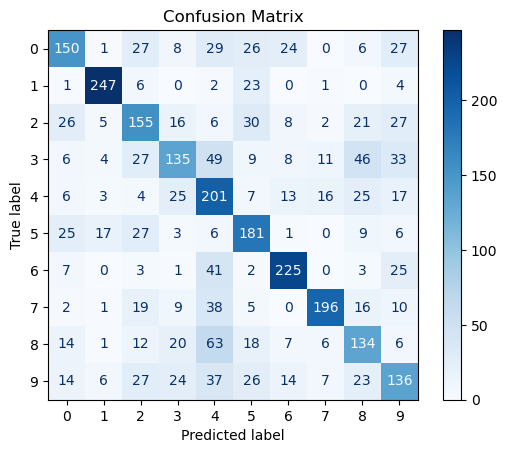

In [14]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow as tf
import matplotlib.pyplot as plt

# Path to JSON file that stores MFCCs and genre labels for each processed segment
DATA_PATH = r"C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project\yash.json"

def load_data(data_path):
    """Loads training dataset from JSON file.

        :param data_path (str): Path to JSON file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """
    with open(data_path, "r") as fp:
        data = json.load(fp)

    # Convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data successfully loaded!")

    return X, y

def plot_confusion_matrix(cm, class_names):
    """Plots confusion matrix using Scikit-Learn's ConfusionMatrixDisplay.

        :param cm (ndarray): Confusion matrix
        :param class_names (list): List of class names
    """
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

if __name__ == "__main__":
    # Load data
    X, y = load_data(DATA_PATH)

    # Create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # Build network topology
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

        # 1st dense layer
        tf.keras.layers.Dense(512, activation='relu'),

        # 2nd dense layer
        tf.keras.layers.Dense(256, activation='relu'),

        # 3rd dense layer
        tf.keras.layers.Dense(64, activation='relu'),

        # Output layer
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    # Compile model
    optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # Train model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=50)

    # Predict on test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)

    # Print classification report
    class_names = [str(i) for i in range(10)]  # Assuming 10 classes, update as needed
    print("Classification Report:\n", classification_report(y_test, y_pred_classes, target_names=class_names))

    # Plot confusion matrix
    plot_confusion_matrix(cm, class_names)


# Solving overfitting in neural networks

Data successfully loaded!


C:\Users\yashm\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 1690)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       865,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,014,218 (3.87 MB)

 Trainable params: 1,014,218 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.1318 - loss: 44.3672 - val_accuracy: 0.2530 - val_loss: 3.7159
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1665 - loss: 7.9000 - val_accuracy: 0.1402 - val_loss: 3.4413
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1598 - loss: 4.7631 - val_accuracy: 0.1298 - val_loss: 3.4638
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1371 - loss: 4.1086 - val_accuracy: 0.1345 - val_loss: 3.4558
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1520 - loss: 3.7728 - val_accuracy: 0.1352 - val_loss: 3.4344
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1531 - loss: 3.6328 - val_accuracy: 0.1465 - val_loss: 3.4079
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1656 - loss: 3.5444 - val_accuracy: 0.1692 - val_loss: 3.3859
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1699 - loss: 3.5066 - val_acc

Epoch 51/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4613 - loss: 2.0899 - val_accuracy: 0.4853 - val_loss: 2.0730
Epoch 52/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4852 - loss: 1.9928 - val_accuracy: 0.4760 - val_loss: 2.0936
Epoch 53/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4834 - loss: 2.0108 - val_accuracy: 0.4670 - val_loss: 2.0573
Epoch 54/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4937 - loss: 1.9600 - val_accuracy: 0.4713 - val_loss: 2.0961
Epoch 55/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4956 - loss: 1.9471 - val_accuracy: 0.4853 - val_loss: 2.0362
Epoch 56/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5080 - loss: 1.9099 - val_accuracy: 0.4873 - val_loss: 2.0397
Epoch 57/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5076 - loss: 1.8678 - val_accuracy: 0.4933 - val_loss: 2.0252
Epoch 58/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5204 - loss: 1.8496 - 

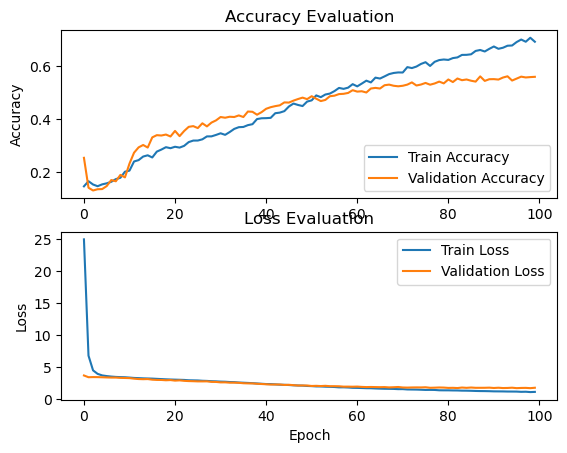

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.41      0.49       301
           1       0.84      0.84      0.84       307
           2       0.44      0.41      0.42       313
           3       0.46      0.41      0.43       285
           4       0.53      0.43      0.47       288
           5       0.46      0.61      0.53       298
           6       0.68      0.81      0.74       278
           7       0.71      0.79      0.75       300
           8       0.50      0.50      0.50       311
           9       0.37      0.39      0.38       315

    accuracy                           0.56      2996
   macro avg       0.56      0.56      0.56      2996
weighted avg       0.56      0.56      0.55      2996



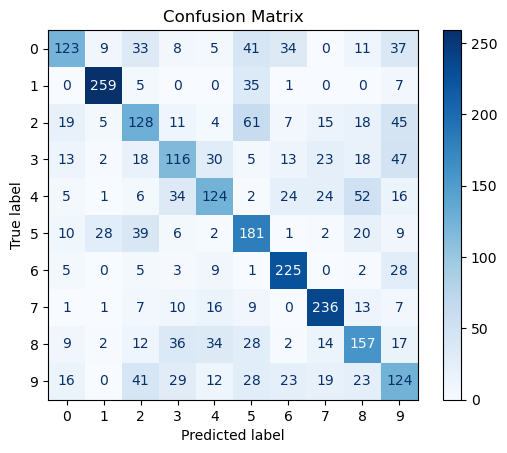

In [15]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow.keras as keras
import matplotlib.pyplot as plt

# Path to JSON file that stores MFCCs and genre labels for each processed segment
DATA_PATH = r"C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project\yash.json"

def load_data(data_path):
    """Loads training dataset from JSON file.

        :param data_path (str): Path to JSON file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """
    with open(data_path, "r") as fp:
        data = json.load(fp)

    # Convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data successfully loaded!")

    return X, y

def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """
    fig, axs = plt.subplots(2)

    # Create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="Train Accuracy")
    axs[0].plot(history.history["val_accuracy"], label="Validation Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy Evaluation")

    # Create error subplot
    axs[1].plot(history.history["loss"], label="Train Loss")
    axs[1].plot(history.history["val_loss"], label="Validation Loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss Evaluation")

    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plots confusion matrix using Scikit-Learn's ConfusionMatrixDisplay.

        :param y_true (ndarray): True labels
        :param y_pred (ndarray): Predicted labels
        :param class_names (list): List of class names
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

if __name__ == "__main__":
    # Load data
    X, y = load_data(DATA_PATH)

    # Create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # Build network topology
    model = keras.Sequential([
        # Input layer
        keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

        # 1st dense layer
        keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),

        # 2nd dense layer
        keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),

        # 3rd dense layer
        keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),

        # Output layer
        keras.layers.Dense(10, activation='softmax')
    ])

    # Compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # Train model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100)

    # Plot accuracy and error as a function of the epochs
    plot_history(history)

    # Predict on test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generate classification report
    class_names = [str(i) for i in range(10)]  # Assuming 10 classes, update as needed
    print("Classification Report:\n", classification_report(y_test, y_pred_classes, target_names=class_names))

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred_classes, class_names)


C:\Users\yashm\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 6, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 4, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 2, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 31, 2, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 1, 32)      │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 1, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │        30,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,514 (177.79 KB)

 Trainable params: 45,322 (177.04 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.1687 - loss: 2.7673 - val_accuracy: 0.3231 - val_loss: 1.9783
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3161 - loss: 2.0474 - val_accuracy: 0.4246 - val_loss: 1.6583
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.3859 - loss: 1.8024 - val_accuracy: 0.4753 - val_loss: 1.5101
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4383 - loss: 1.6218 - val_accuracy: 0.5087 - val_loss: 1.3897
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4736 - loss: 1.4962 - val_accuracy: 0.5360 - val_loss: 1.3146
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4942 - loss: 1.4237 - val_accuracy: 0.5501 - val_loss: 1.2741
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5004 - loss: 1.3948 - val_accuracy: 0.5614 - val_loss: 1.2164
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5254 - loss: 1.3399 - val_accu

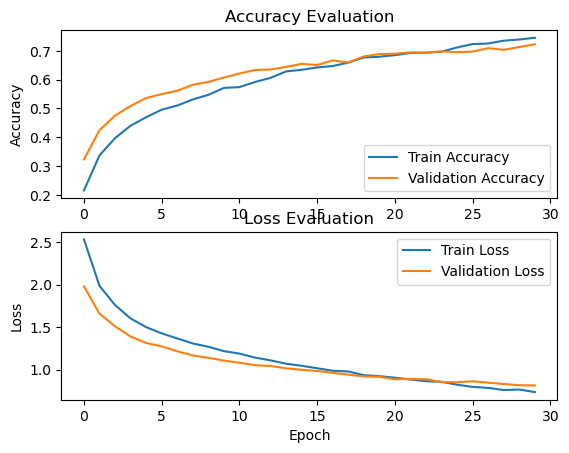

79/79 - 0s - 6ms/step - accuracy: 0.7113 - loss: 0.8370

Test accuracy: 0.7112535238265991
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.75      0.71       248
           1       0.84      0.94      0.89       247
           2       0.59      0.59      0.59       236
           3       0.63      0.60      0.61       254
           4       0.71      0.75      0.73       259
           5       0.73      0.81      0.77       226
           6       0.77      0.83      0.80       264
           7       0.82      0.75      0.78       259
           8       0.75      0.62      0.68       256
           9       0.57      0.47      0.51       248

    accuracy                           0.71      2497
   macro avg       0.71      0.71      0.71      2497
weighted avg       0.71      0.71      0.71      2497



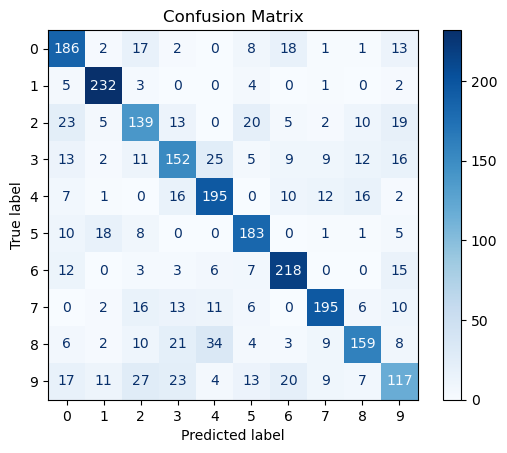

In [16]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATA_PATH = r"C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project\yash.json"

def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """
    fig, axs = plt.subplots(2)

    # Create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="Train Accuracy")
    axs[0].plot(history.history["val_accuracy"], label="Validation Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy Evaluation")

    # Create loss subplot
    axs[1].plot(history.history["loss"], label="Train Loss")
    axs[1].plot(history.history["val_loss"], label="Validation Loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss Evaluation")

    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plots confusion matrix using Scikit-Learn's ConfusionMatrixDisplay.

        :param y_true (ndarray): True labels
        :param y_pred (ndarray): Predicted labels
        :param class_names (list): List of class names
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.

    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split

    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """
    # Load data
    X, y = load_data(DATA_PATH)

    # Create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # Add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

def build_model(input_shape):
    """Generates CNN model

    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """
    # Build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # Flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # Output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

def predict(model, X, y):
    """Predict a single sample using the trained model

    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """
    # Add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...]  # Array shape (1, 130, 13, 1)

    # Perform prediction
    prediction = model.predict(X)

    # Get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

if __name__ == "__main__":
    # Get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # Create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # Compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # Train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

    # Plot accuracy/error for training and validation
    plot_history(history)

    # Evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # Predict on test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generate classification report
    class_names = [str(i) for i in range(10)]  # Assuming 10 classes, update as needed
    print("Classification Report:\n", classification_report(y_test, y_pred_classes, target_names=class_names))

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred_classes, class_names)




In [17]:
    # pick a sample to predict from the test set
    X_to_predict = X_test[90]
    y_to_predict = y_test[90]

    # predict sample
    predict(model, X_to_predict, y_to_predict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Target: 2, Predicted label: [0]


# How to implement an RNN-LSTM for music genre classification

C:\Users\yashm\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 130, 64)        │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,802 (225.79 KB)

 Trainable params: 57,802 (225.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step - accuracy: 0.1741 - loss: 2.2224 - val_accuracy: 0.2750 - val_loss: 2.0257
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.3012 - loss: 1.9776 - val_accuracy: 0.3725 - val_loss: 1.8067
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step - accuracy: 0.3865 - loss: 1.7865 - val_accuracy: 0.4152 - val_loss: 1.6315
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.4363 - loss: 1.6317 - val_accuracy: 0.4466 - val_loss: 1.5324
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.4489 - loss: 1.5543 - val_accuracy: 0.4786 - val_loss: 1.4548
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.4902 - loss: 1.4483 - val_accuracy: 0.4846 - val_loss: 1.4356
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step - accuracy: 0.5043 - loss: 1.4218 - val_accuracy: 0.5080 - val_loss: 1.3688
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step - accuracy: 0.5123 - loss: 1.3734

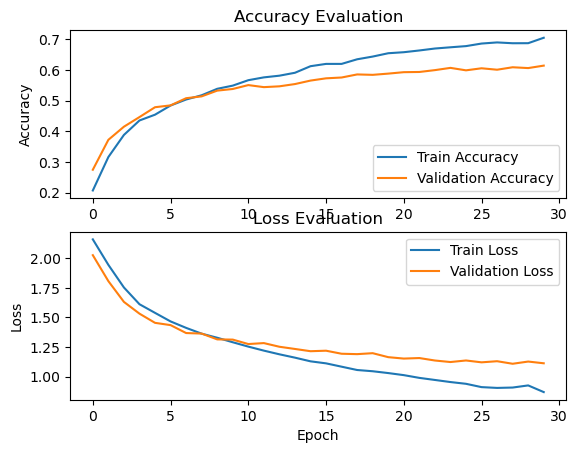

79/79 - 2s - 28ms/step - accuracy: 0.6296 - loss: 1.0873

Test accuracy: 0.6295554637908936
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.60      0.60       248
           1       0.86      0.93      0.90       241
           2       0.49      0.49      0.49       252
           3       0.50      0.56      0.53       247
           4       0.54      0.60      0.57       278
           5       0.61      0.58      0.59       259
           6       0.89      0.80      0.84       234
           7       0.84      0.80      0.82       281
           8       0.52      0.55      0.54       251
           9       0.42      0.33      0.37       206

    accuracy                           0.63      2497
   macro avg       0.63      0.63      0.63      2497
weighted avg       0.63      0.63      0.63      2497



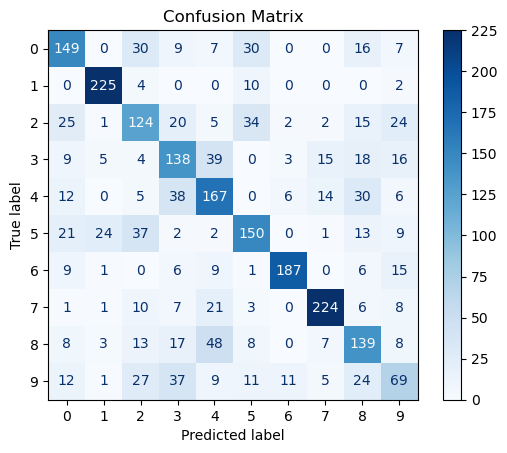

In [18]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATA_PATH = r"C:\Users\yashm\OneDrive\Desktop\CV Building Documents\Project\yash.json"

def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """
    fig, axs = plt.subplots(2)

    # Create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="Train Accuracy")
    axs[0].plot(history.history["val_accuracy"], label="Validation Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy Evaluation")

    # Create loss subplot
    axs[1].plot(history.history["loss"], label="Train Loss")
    axs[1].plot(history.history["val_loss"], label="Validation Loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss Evaluation")

    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plots confusion matrix using Scikit-Learn's ConfusionMatrixDisplay.

        :param y_true (ndarray): True labels
        :param y_pred (ndarray): Predicted labels
        :param class_names (list): List of class names
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.

    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split

    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """
    # Load data
    X, y = load_data(DATA_PATH)

    # Create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, X_validation, X_test, y_train, y_validation, y_test

def build_model(input_shape):
    """Generates RNN-LSTM model

    :param input_shape (tuple): Shape of input set
    :return model: RNN-LSTM model
    """
    # Build network topology
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(64))

    # Dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # Output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

if __name__ == "__main__":
    # Get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # Create network
    input_shape = (X_train.shape[1], X_train.shape[2])  # Example shape: (130, 13)
    model = build_model(input_shape)

    # Compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # Train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

    # Plot accuracy/loss for training and validation
    plot_history(history)

    # Evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # Predict on test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generate classification report
    class_names = [str(i) for i in range(10)]  # Assuming 10 classes, update as needed
    print("Classification Report:\n", classification_report(y_test, y_pred_classes, target_names=class_names))

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred_classes, class_names)


https://medium.com/@nakul.havaldar/music-genre-classification-fa7a63362d21
    https://www.youtube.com/watch?v=dOG-HxpbMSw